# Blast similarity in test set

Evaluate whether the test set contains significant similarity to train set, and do some downstream analyses accordingly.

In [2]:
import os
import sys
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import xgboost as xgb

from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

# Figure out local paths
SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import utils
import seq

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

np.random.seed(27492)
SEED = 27492

print('The scikit-learn version is {}.'.format(sklearn.__version__))

INFO:root:CPU


The scikit-learn version is 0.21.3.


In [3]:
importlib.reload(data_loader)
K_FOLD = 5
train_dataset = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
valid_dataset = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
test_dataset = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
full_dataset = data_loader.LocalizationClassificationKmers("all", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
train_data = data_loader.load_data_as_np(train_dataset)
valid_data = data_loader.load_data_as_np(valid_dataset)
test_data = data_loader.load_data_as_np(test_dataset)
full_data = data_loader.load_data_as_np(full_dataset)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [30]:
test_data[0].shape

(366, 4032)

In [10]:
train_sequences = [train_dataset.get_ith_trans_seq(i) for i in range(len(train_dataset))]
train_sequence_names = [train_dataset.full_deseq_table.gene_name[i] for i in range(len(train_dataset))]

In [11]:
test_sequences = [test_dataset.get_ith_trans_seq(i) for i in range(len(test_dataset))]
test_sequence_names = [test_dataset.full_deseq_table.gene_name[i] for i in range(len(test_dataset))]

In [27]:
print(test_sequence_names[:10])

['TCF25', 'VCPIP1', 'LPCAT1', 'LINC02057', 'HOXA10-AS', 'NEK1', 'ELOVL7', 'SOX13', 'PRR3', 'ARHGEF11']


In [80]:
"MEG3" in train_sequence_names

False

In [15]:
def write_fasta(seq_tuples, fa_file):
    """
    Given tuples of (gene_name, gene_seq) write them to fasta file
    """
    seen_names = set()
    with open(fa_file, 'w') as sink:
        for seq_name, seq in seq_tuples:
            while seq_name in seen_names:
                seq_name += "`prime"
            seen_names.add(seq_name)
            sink.write(">" + seq_name + "\n")
            sink.write(seq + "\n")
    return fa_file

write_fasta(zip(train_sequence_names, train_sequences), f"multi_localization_kmer_blast_similarity/kfold_{K_FOLD}_train.fa")
write_fasta(zip(test_sequence_names, test_sequences), f"multi_localization_kmer_blast_similarity/kfold_{K_FOLD}_test.fa")

'multi_localization_kmer_blast_similarity/kfold_5_test.fa'

Blast 2.9.0

To make the blast database
```
makeblastdb -in kfold_5_train.fa -parse_seqids -title "kfold5train" -dbtype nucl
```
To query
```
blastn -db kfold_5_train.fa -query kfold_5_test.fa -out kfold_5_test.out -outfmt "10 qseqid sseqid evalue qlen qstart qend slen sstart send length pident nident"
```

In [24]:
import json

def read_blast_out(fname=f"multi_localization_kmer_blast_similarity/kfold_{K_FOLD}_test.out"):
    """Reads blast output file"""
    retval = pd.read_csv(
        fname,
    )
    retval.columns = [
            'query_id',
            'subject_id',
            'evalue',
            'query_len',
            'query_start',
            'query_end',
            'subject_len',
            'subject_start',
            'subject_end',
            'length',
            'percent_ident',
            'n_ident',
        ]
    return retval

blast_out = read_blast_out()
blast_out.head()

,query_id,subject_id,evalue,query_len,query_start,query_end,subject_len,subject_start,subject_end,length,percent_ident,n_ident
0,VCPIP1,KCTD20,2.870000e-62,9942,8596,8853,5619,4998,4739,260,83.462,217
1,VCPIP1,SFT2D2,1.330000e-60,9942,8604,8853,11040,7291,7540,252,83.730,211
2,VCPIP1,SLC25A25-AS1,4.800000e-60,9942,8603,8866,6391,4449,4712,267,82.772,221
3,VCPIP1,SLC25A25-AS1,2.280000e-43,9942,8590,8843,6391,3360,3615,256,79.297,203
4,VCPIP1,BRCA1,1.720000e-59,9942,8590,8853,7094,6557,6296,268,82.836,222


In [71]:
blast_out_perc_match = blast_out['length'] / blast_out['query_len']
np.mean(blast_out_perc_match), np.median(blast_out_perc_match)

(0.05789766153304503, 0.044634668297156836)

In [69]:
blast_out_lengths = blast_out['length']
print(np.mean(blast_out_lengths), np.median(blast_out_lengths))
print(np.sum(blast_out_lengths > 1500))
blast_out_lengths = blast_out_lengths[blast_out_lengths < 1500]

257.11632834055973 288.0
20


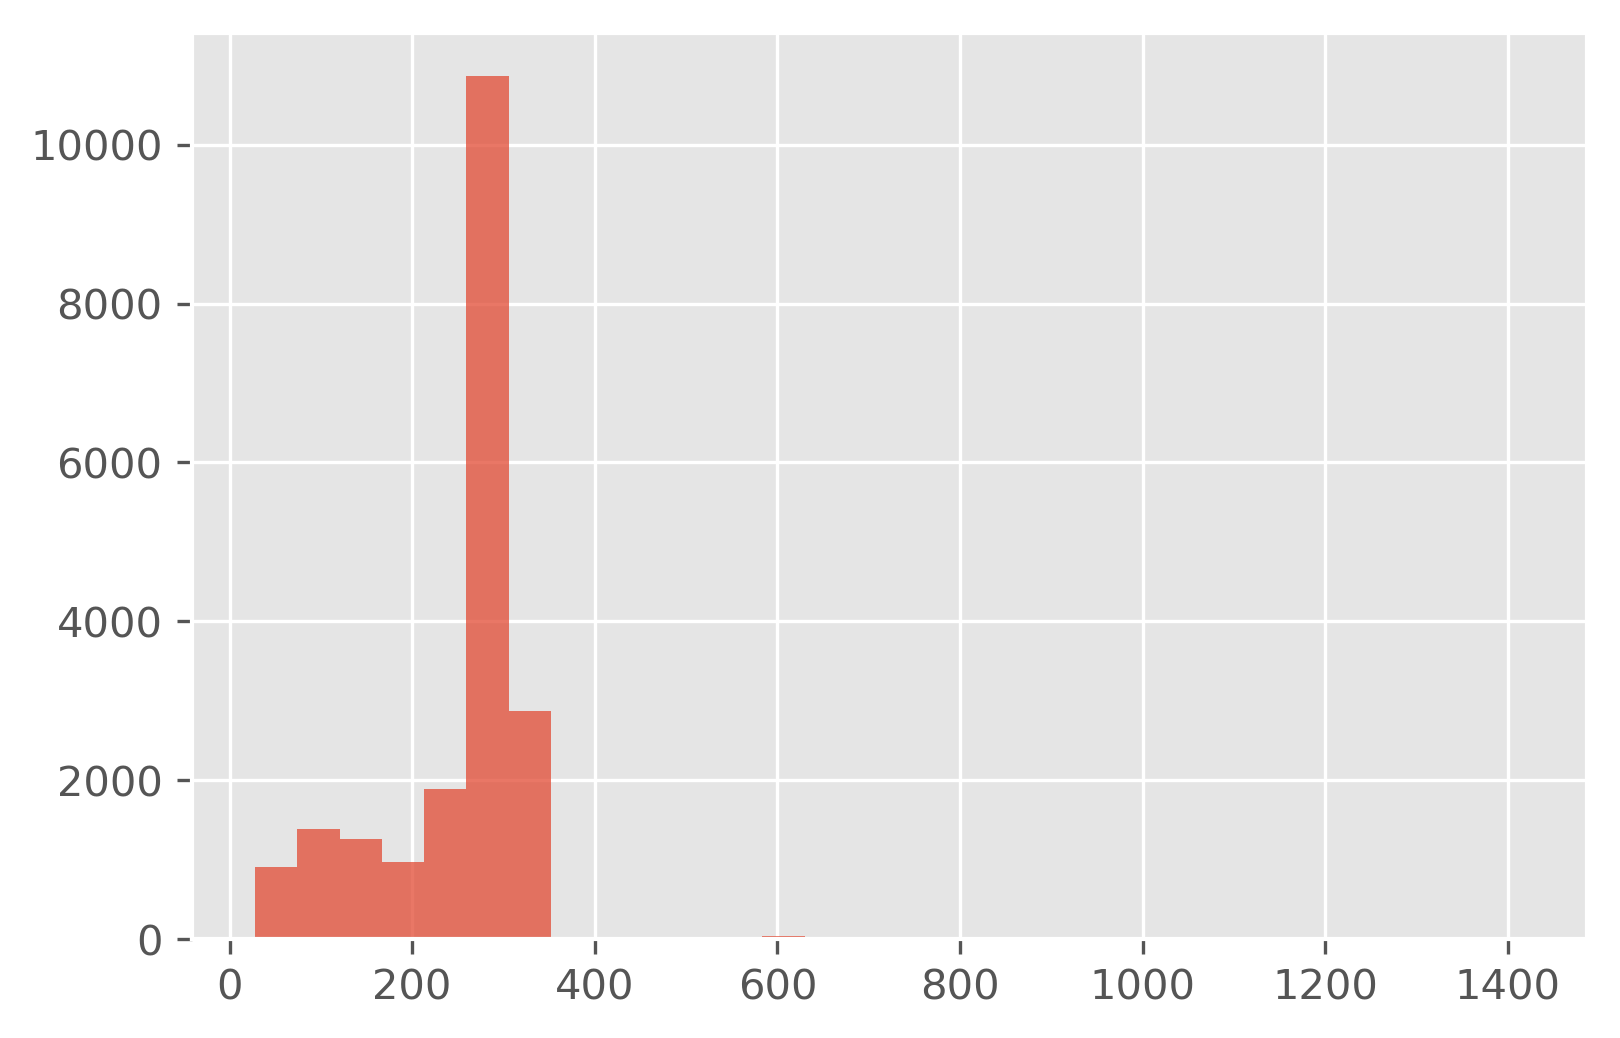

In [72]:
fig, ax = plt.subplots(dpi=300)
ax.hist(blast_out_lengths, alpha=0.75, bins=30)
fig.show()

In [26]:
# Genes/transcripts that have any significant hit
test_genes_with_hit = set(blast_out['query_id'])
len(test_genes_with_hit)

110

In [33]:
test_genes_with_hit_idx = [i for i, gene_name in enumerate(test_sequence_names) if gene_name in test_genes_with_hit]
test_genes_with_hit_idx[:10]

[1, 3, 6, 7, 8, 11, 25, 29, 31, 33]

In [34]:
test_data_with_hit = (
    test_data[0][test_genes_with_hit_idx],
    test_data[1][test_genes_with_hit_idx],
)

In [28]:
test_genes_without_hit_idx = [i for i, gene_name in enumerate(test_sequence_names) if gene_name not in test_genes_with_hit]
test_genes_without_hit_idx[:10]

[0, 2, 4, 5, 9, 10, 12, 13, 14, 15]

In [31]:
test_data_without_hit = (
    test_data[0][test_genes_without_hit_idx],
    test_data[1][test_genes_without_hit_idx],
)

In [35]:
test_data_without_hit[0].shape

(256, 4032)

## Load in model and evaluate

In [37]:
rf = utils.load_sklearn_model(os.path.join(
    os.path.dirname(SRC_DIR),
    "models/rf_8way_fold5.0.21.3.skmodel"
))

In [41]:
rf_no_hit_matrix = model_utils.list_preds_to_array_preds(rf.predict_proba(test_data_without_hit[0]))
rf_no_hit_class_perf = model_utils.generate_multiclass_perf(test_data_without_hit[1], rf_no_hit_matrix, 8)
rf_no_hit_overall_perf = model_utils.generate_model_perf(test_data_without_hit[1], rf_no_hit_matrix, multiclass=True)
print(rf_no_hit_overall_perf.auroc)
print(rf_no_hit_overall_perf.auprc)

0.75369085666139
0.4346339415012236


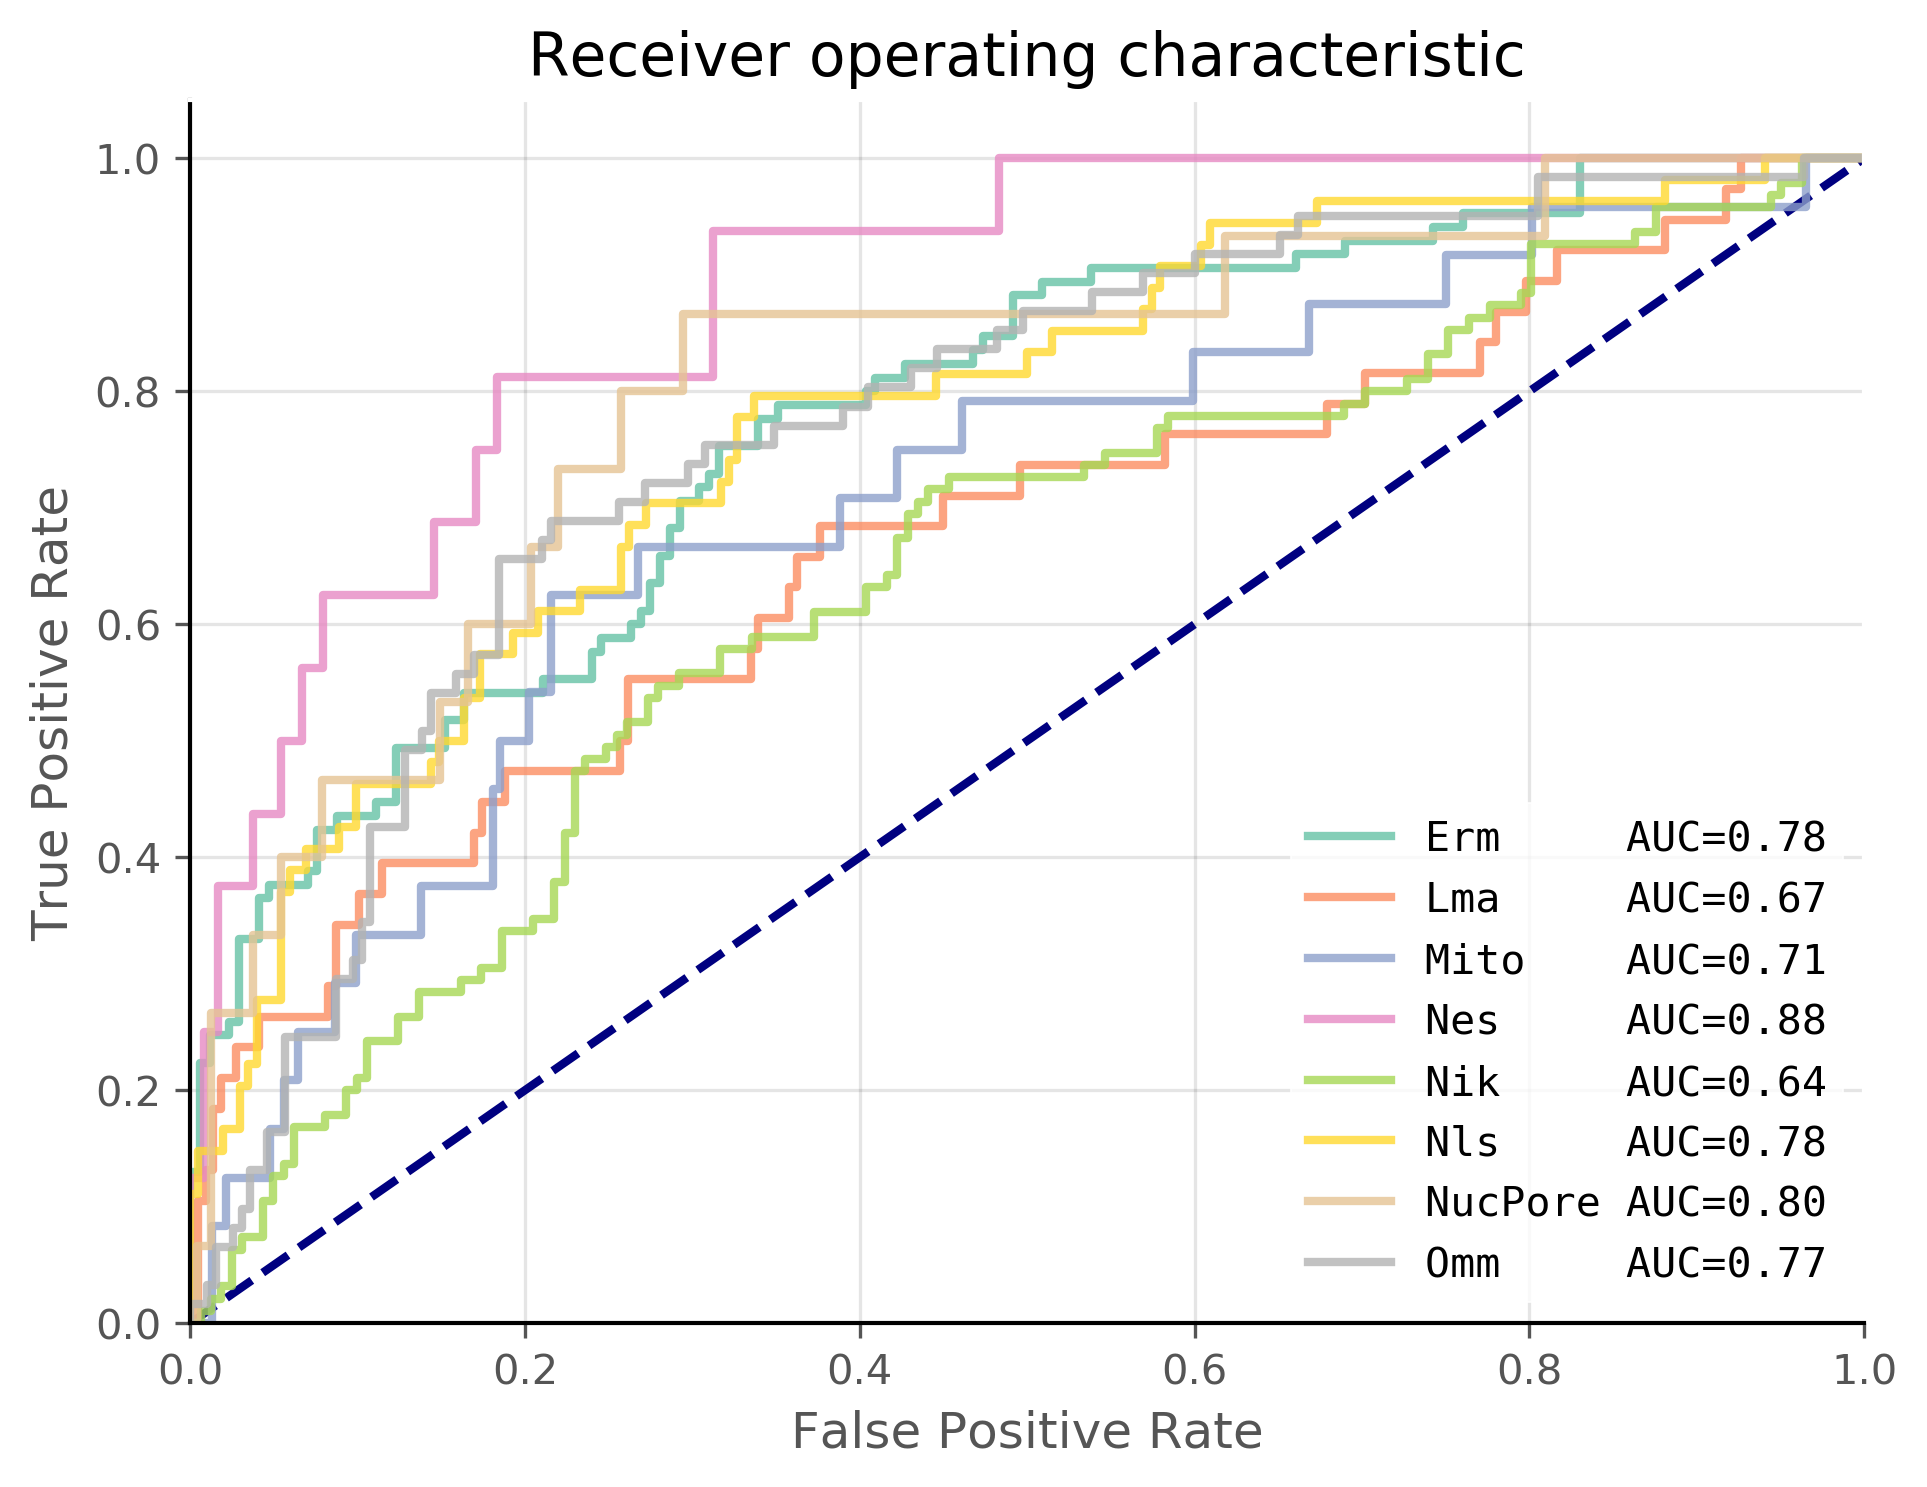

In [81]:
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(test_dataset.compartments, rf_no_hit_class_perf)}
)

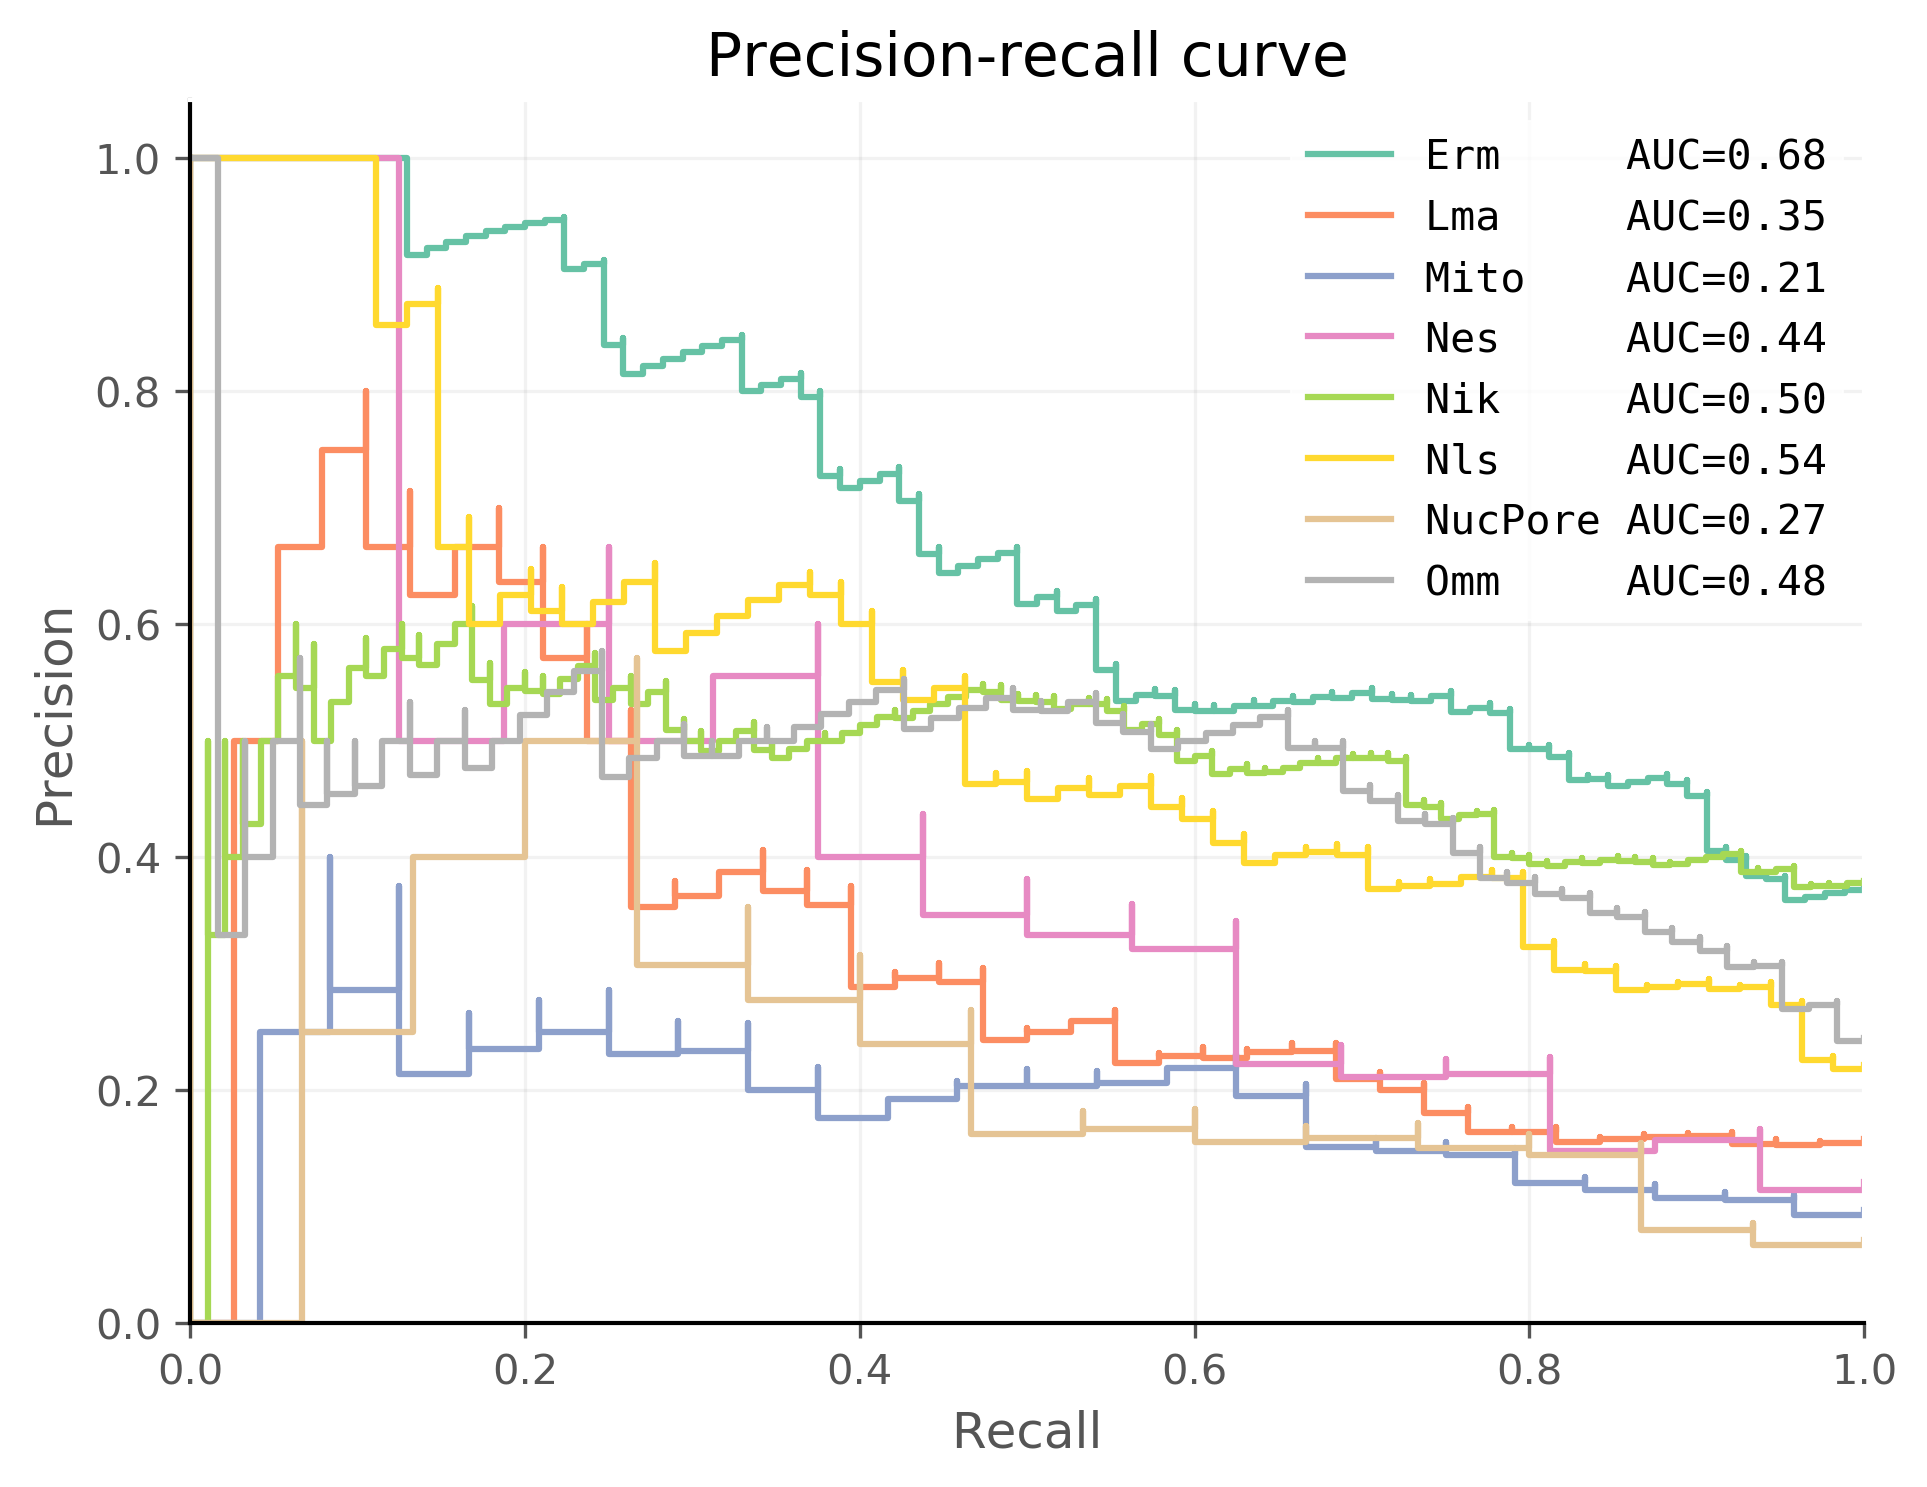

In [49]:
plotting_utils.plot_auprc(
    {localization: perf for localization, perf in zip(test_dataset.compartments, rf_no_hit_class_perf)}
)

In [43]:
rf_hit_matrix = model_utils.list_preds_to_array_preds(rf.predict_proba(test_data_with_hit[0]))
rf_hit_class_perf = model_utils.generate_multiclass_perf(test_data_with_hit[1], rf_hit_matrix, 8)
rf_hit_overall_perf = model_utils.generate_model_perf(test_data_with_hit[1], rf_hit_matrix, multiclass=True)
print(rf_hit_overall_perf.auroc)
print(rf_hit_overall_perf.auprc)

0.7778214533388421
0.6146107048313592


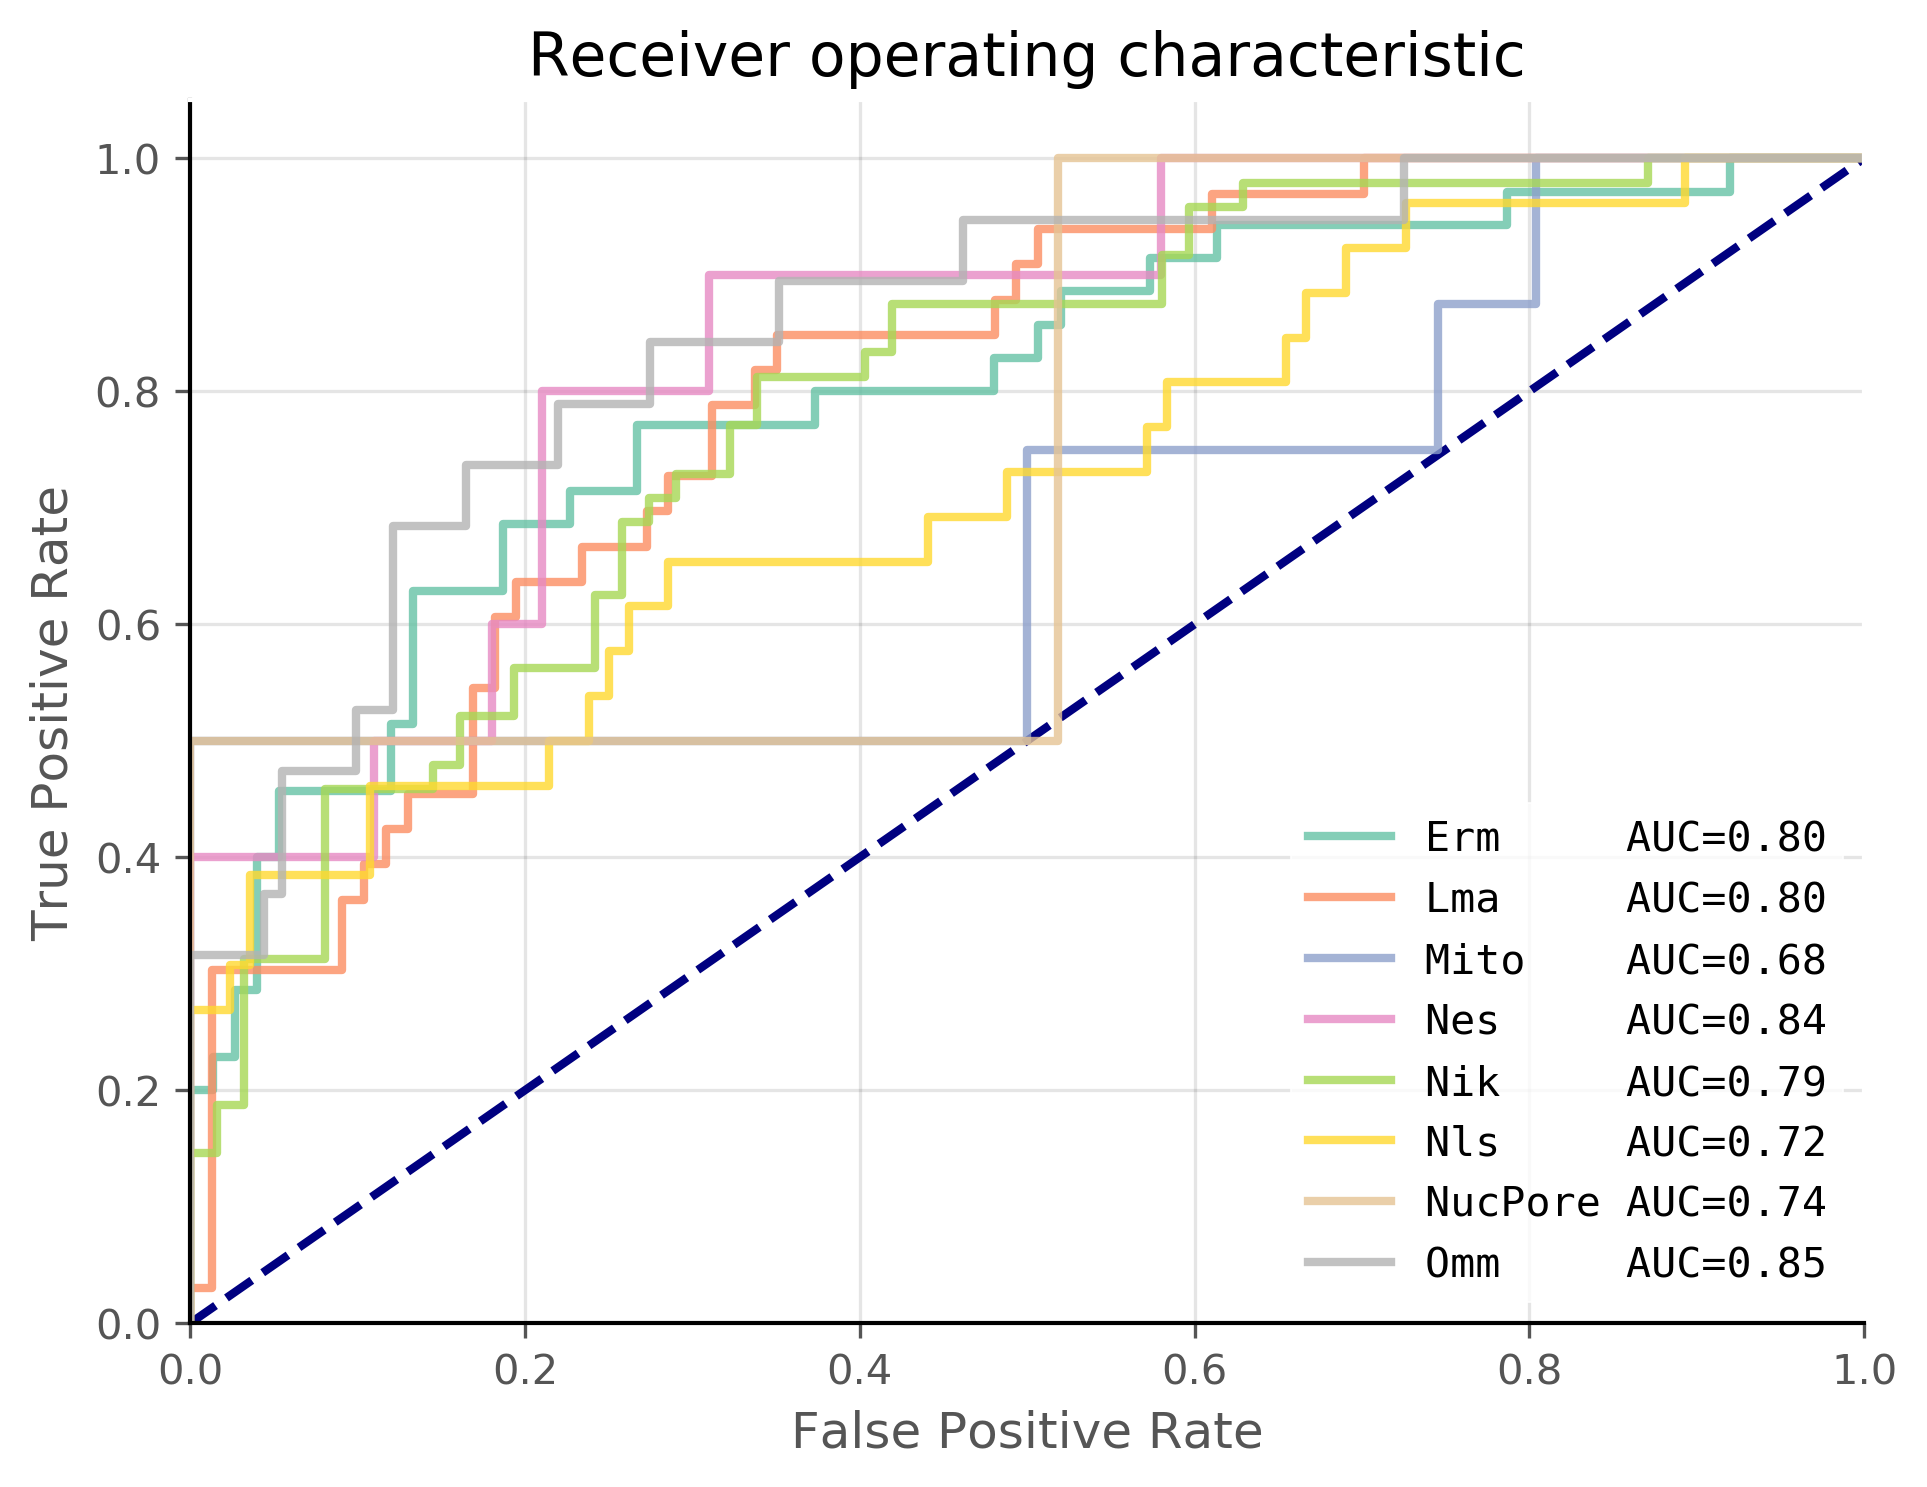

In [82]:
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(test_dataset.compartments, rf_hit_class_perf)}
)

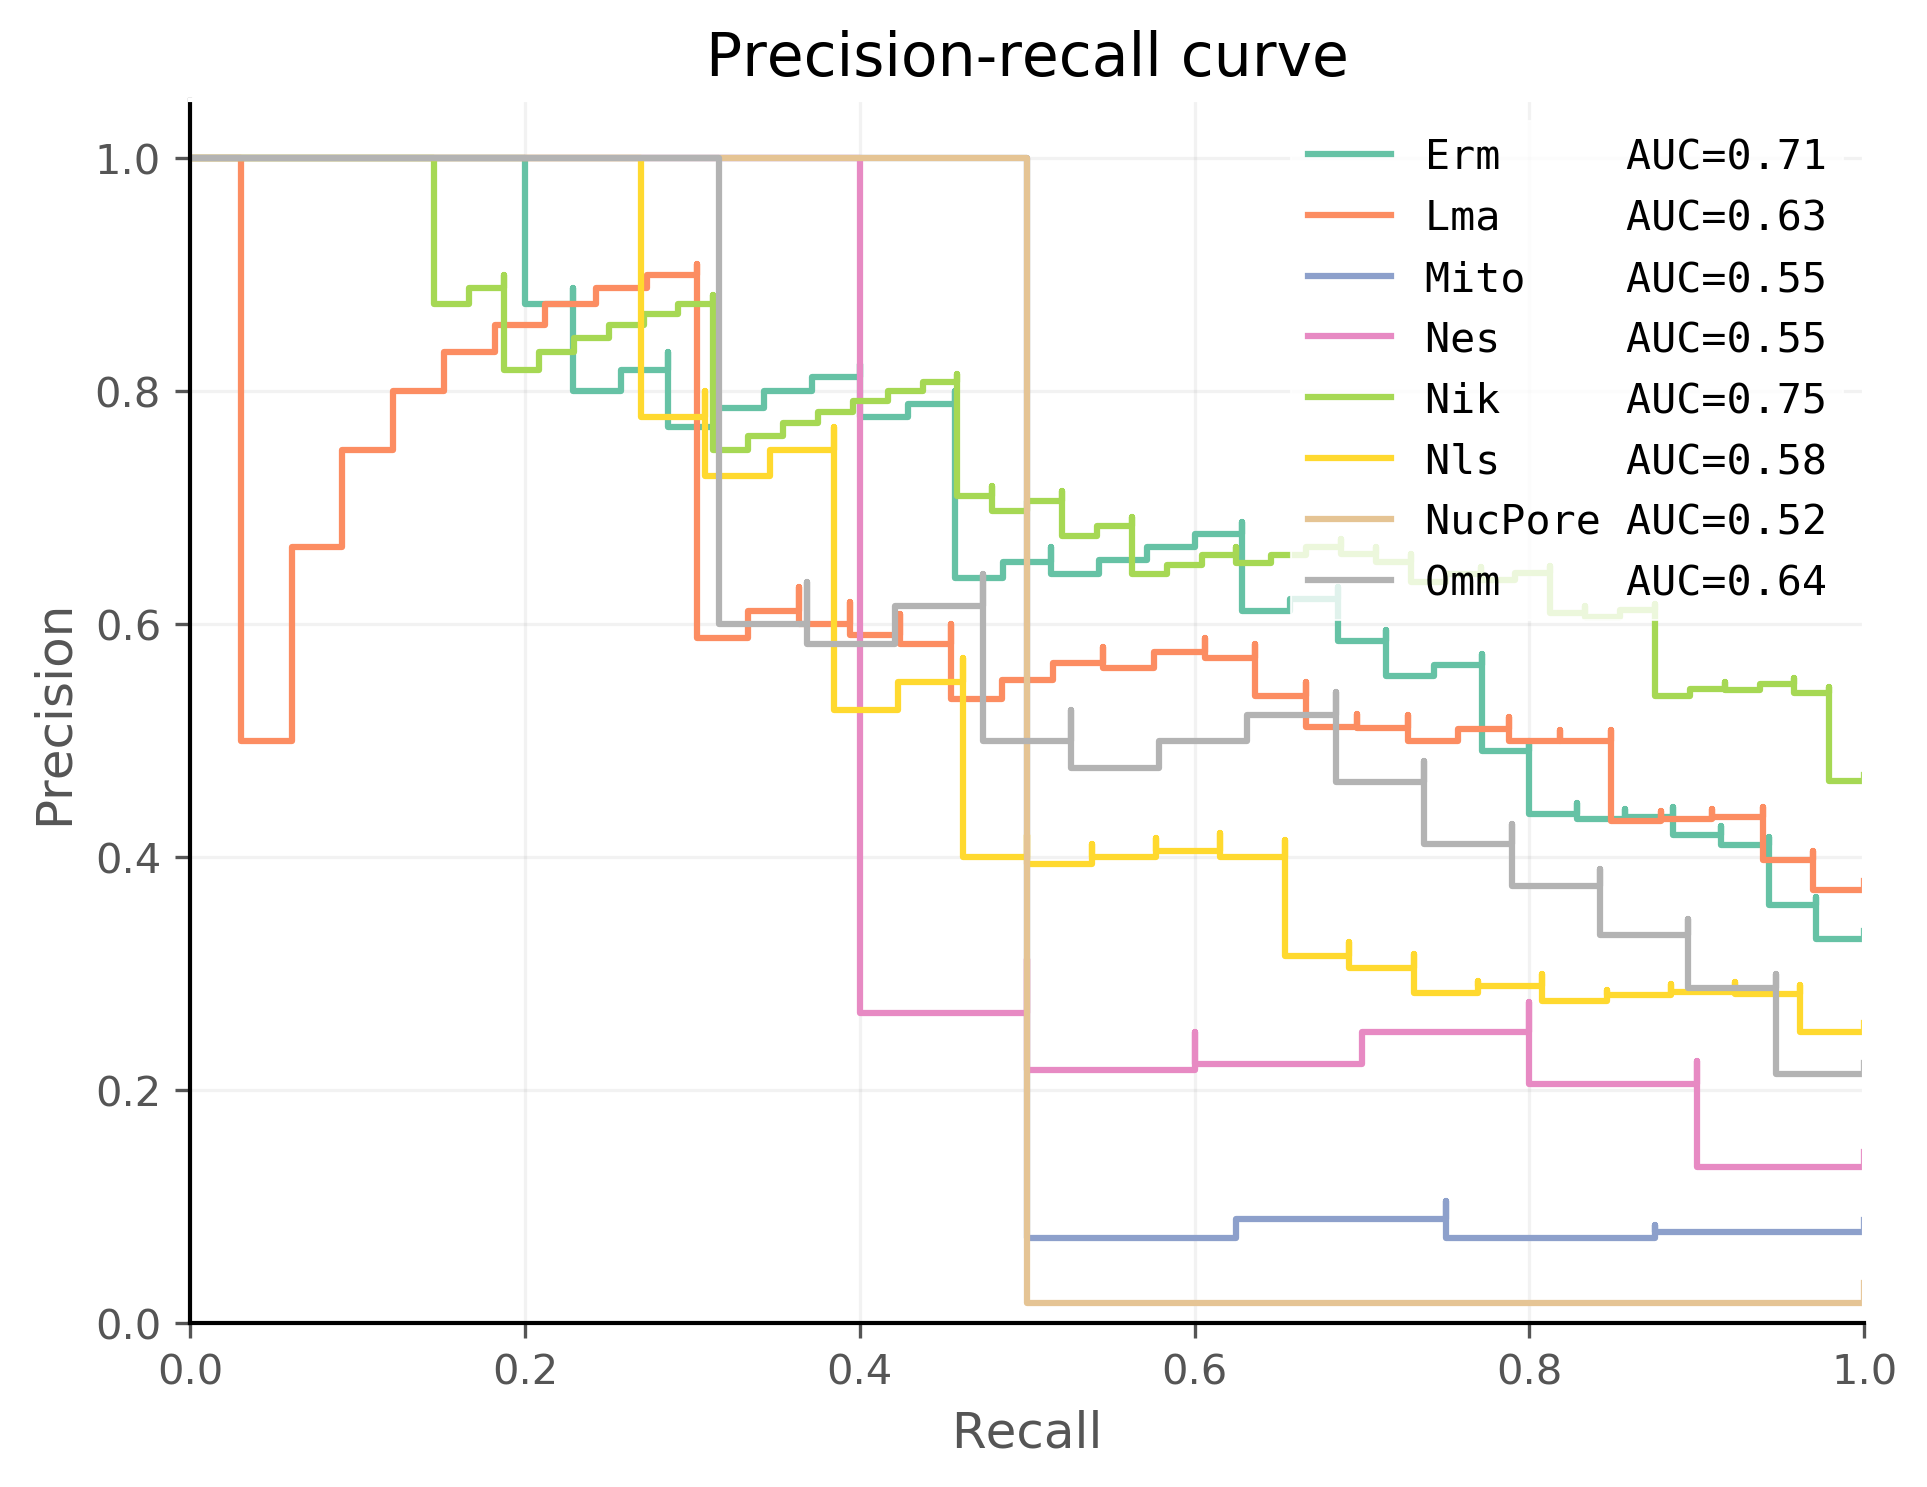

In [48]:
plotting_utils.plot_auprc(
    {localization: perf for localization, perf in zip(test_dataset.compartments, rf_hit_class_perf)}
)

In [44]:
rf_full_matrix = model_utils.list_preds_to_array_preds(rf.predict_proba(test_data[0]))
rf_full_class_perf = model_utils.generate_multiclass_perf(test_data[1], rf_full_matrix, 8)
rf_full_overall_perf = model_utils.generate_model_perf(test_data[1], rf_full_matrix, multiclass=True)
print(rf_full_overall_perf.auroc)
print(rf_full_overall_perf.auprc)

0.7678688021252544
0.49441421899593996


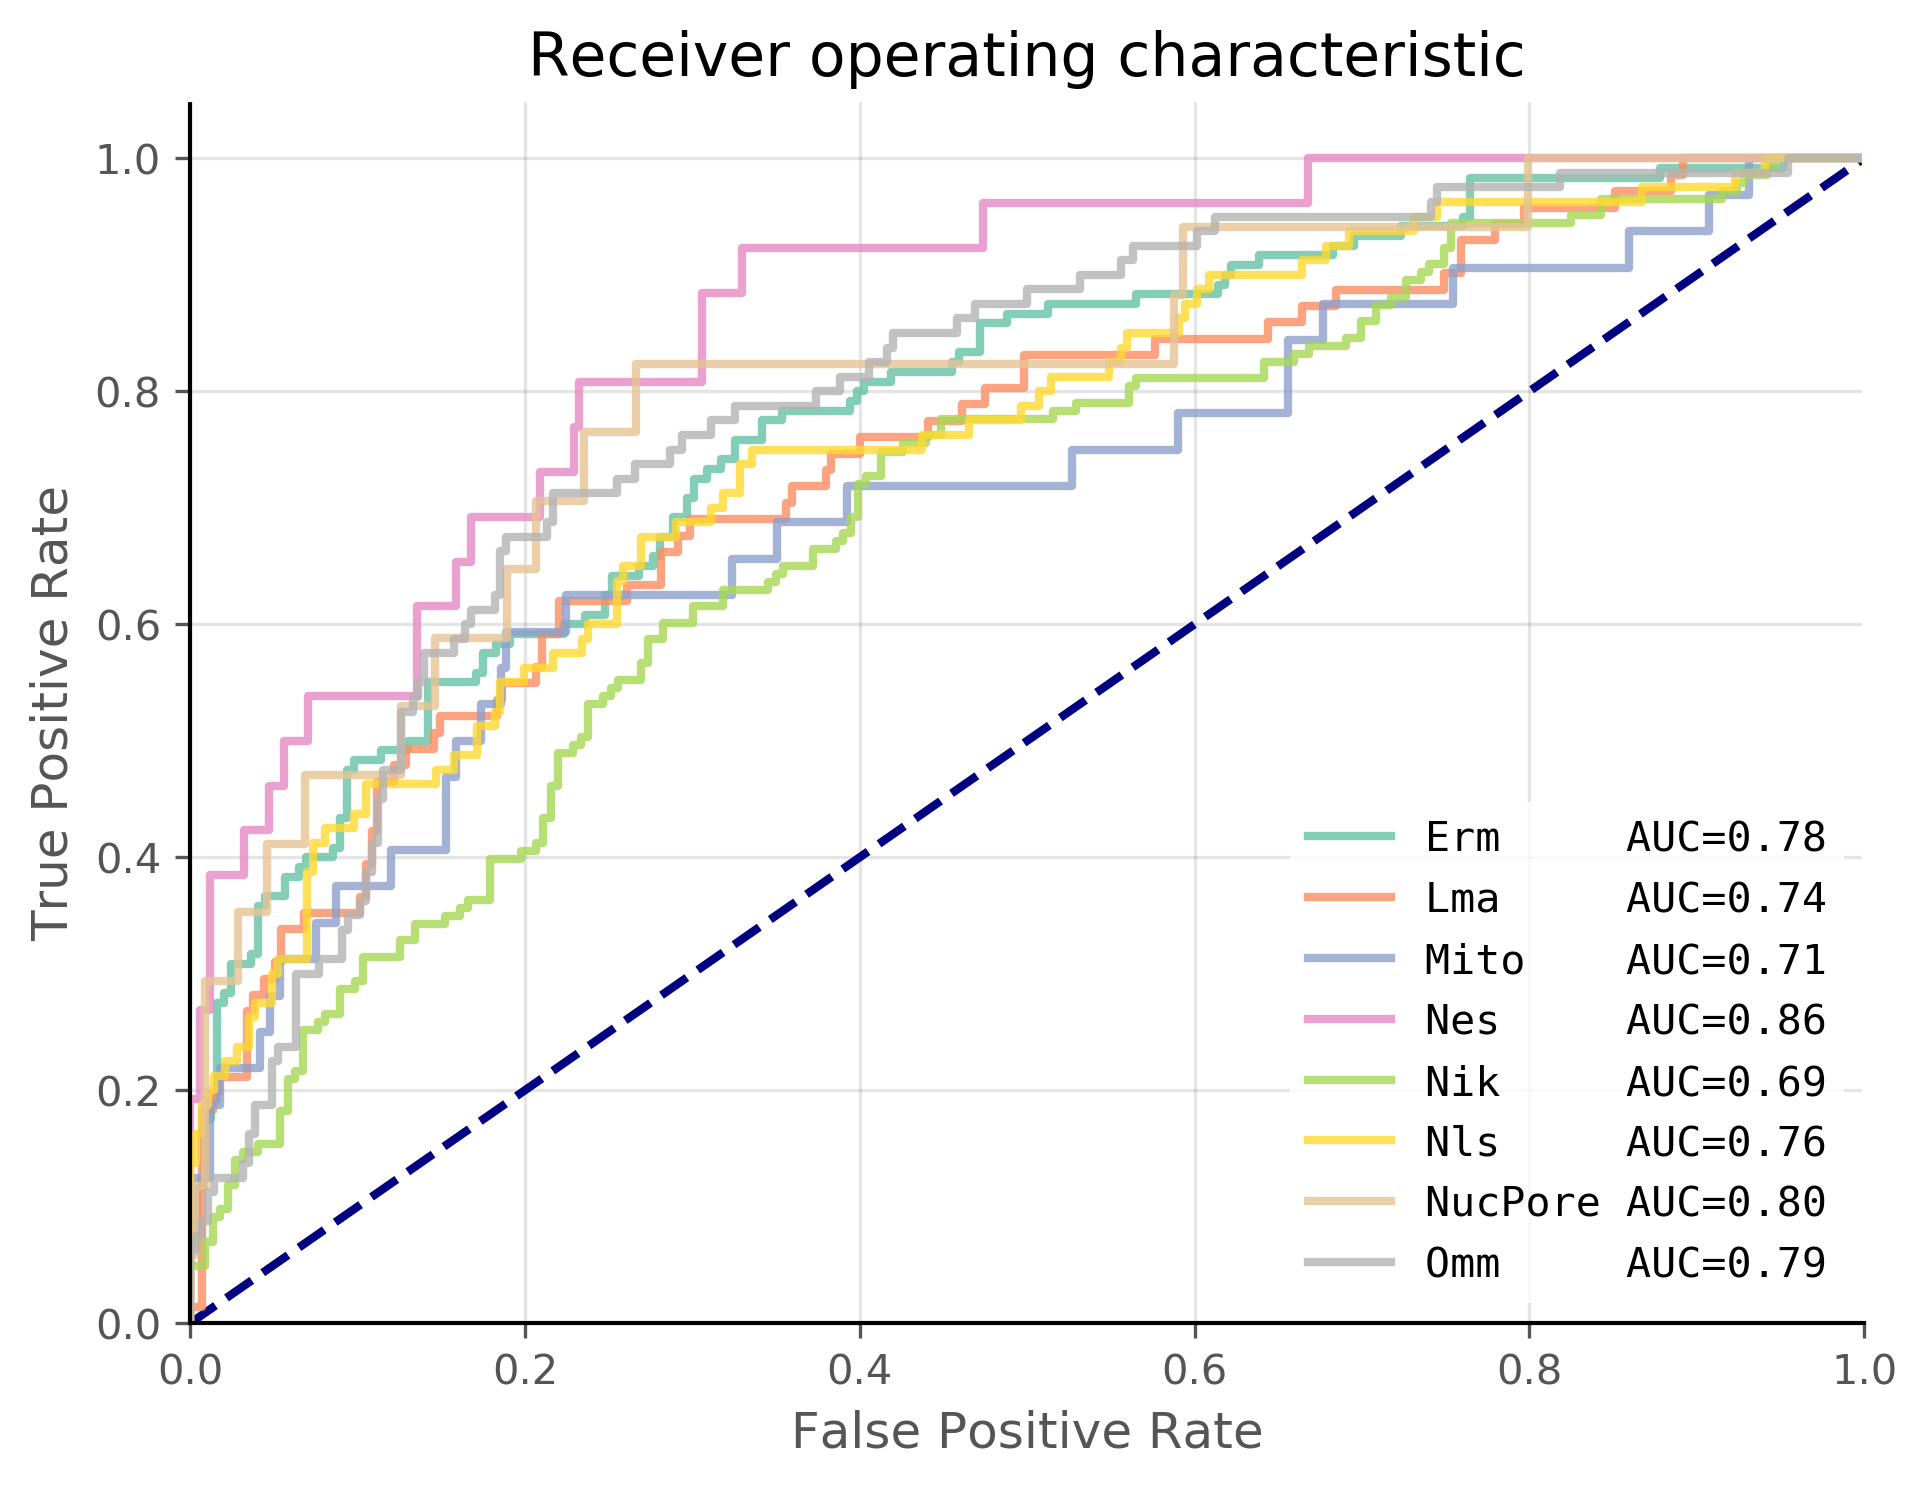

In [83]:
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(test_dataset.compartments, rf_full_class_perf)}
)

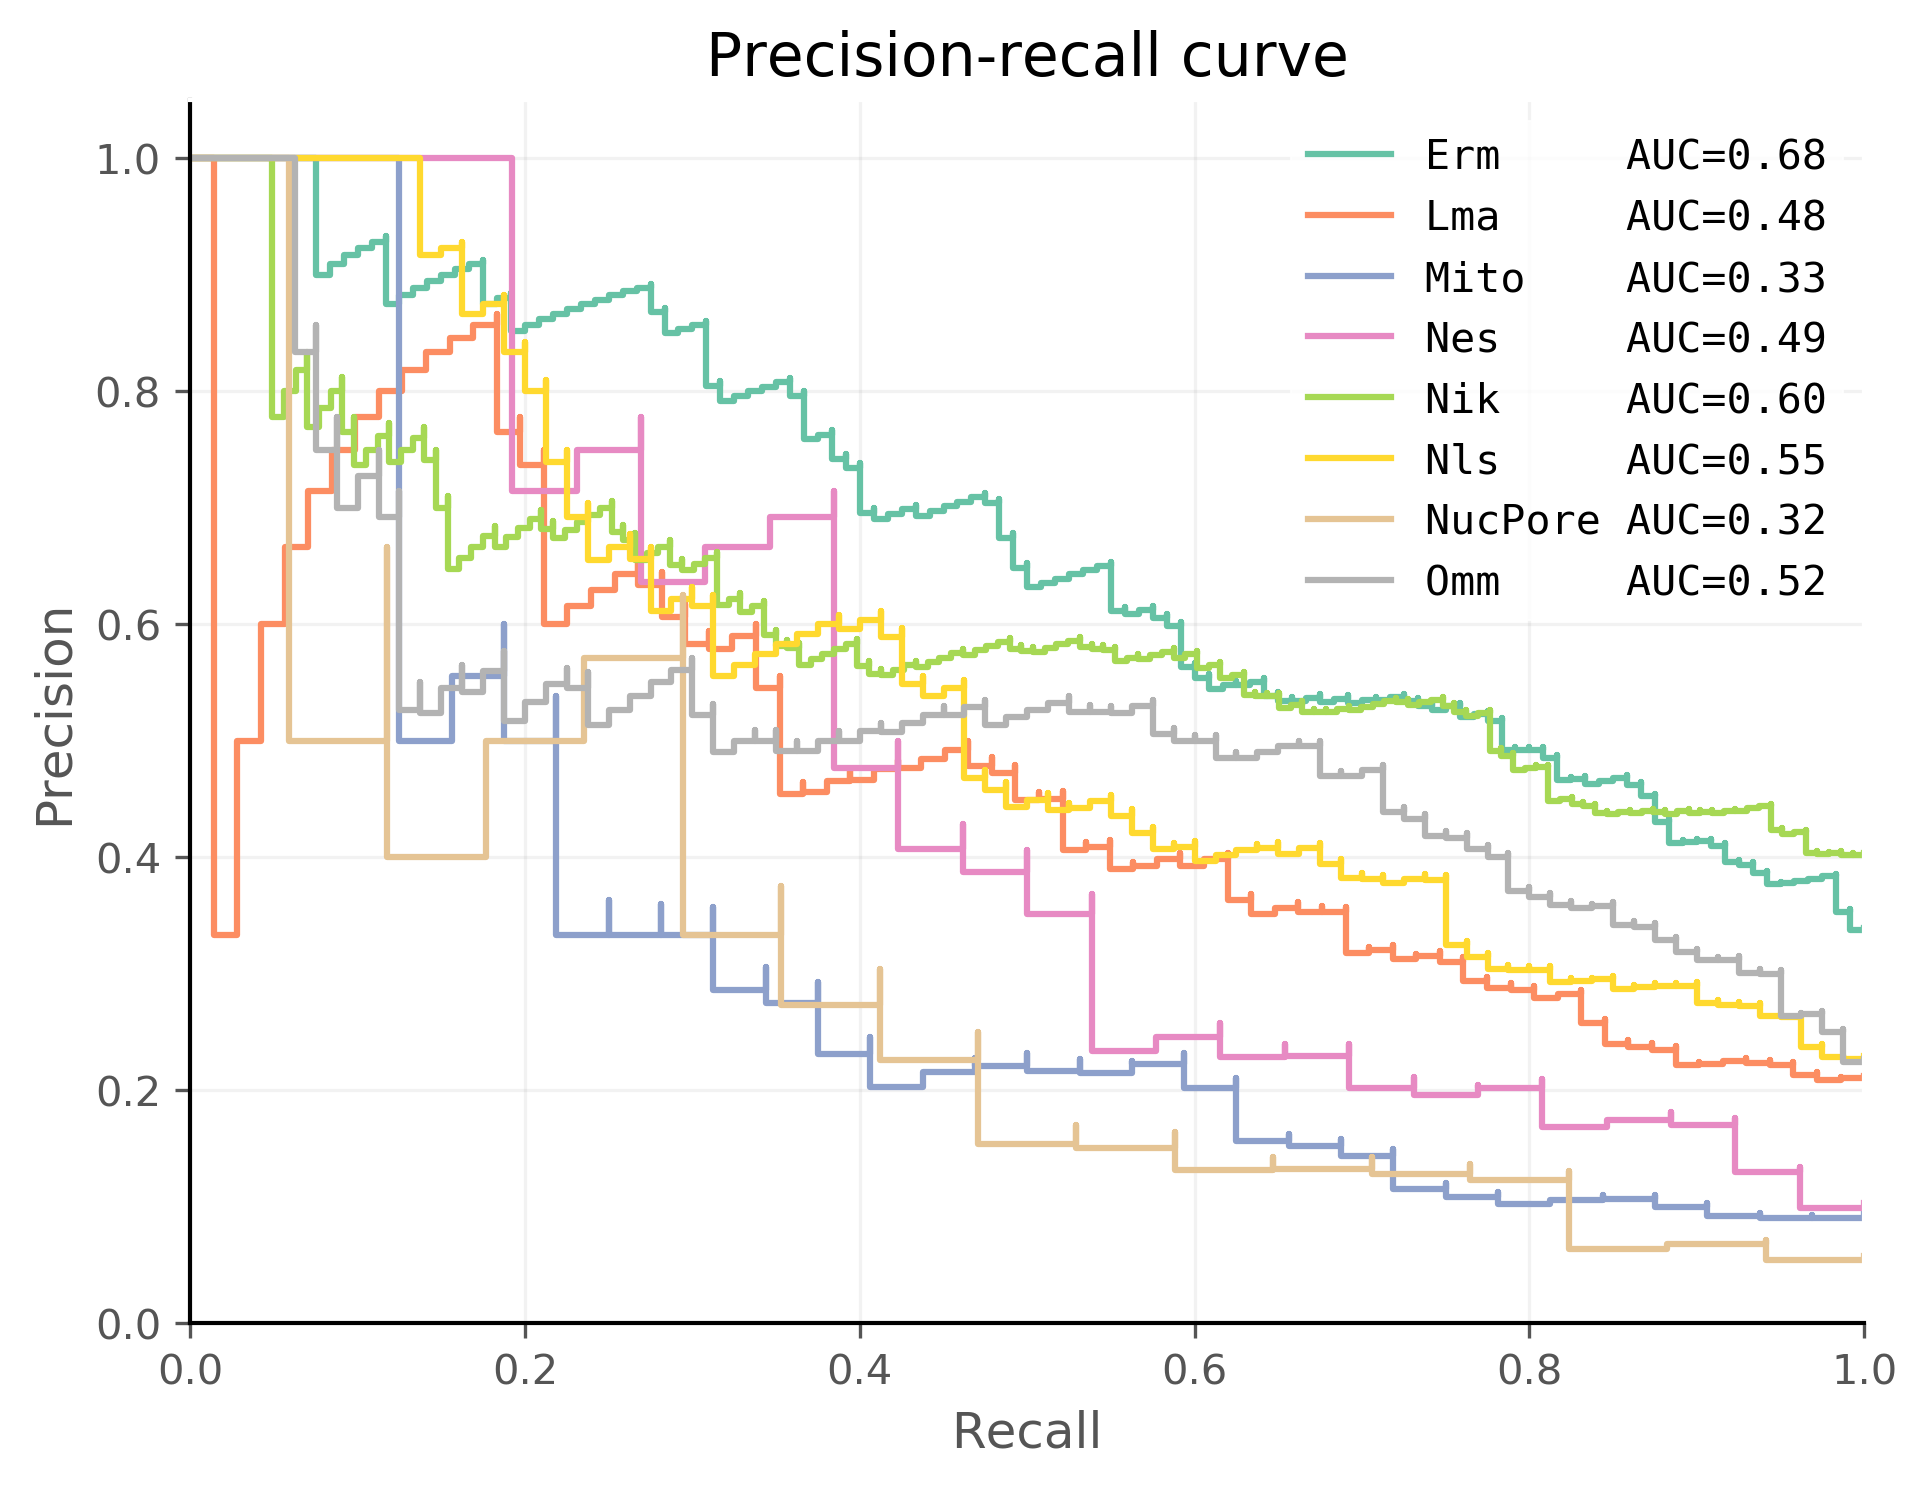

In [47]:
plotting_utils.plot_auprc(
    {localization: perf for localization, perf in zip(test_dataset.compartments, rf_full_class_perf)}
)